# Advanced examples

This is a set of more advanced examples along with some explanations of how they work. The examples are accompanied by a dataset in the `examples/data` folder.

In [33]:
import math
from collections import defaultdict
import matplotlib.ticker as plticker

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.fft import fft, fftfreq
from scipy.ndimage import uniform_filter, uniform_filter1d
from scipy.optimize import curve_fit
from tqdm import tqdm

from cmtj import *
from cmtj import SolverMode
from cmtj.models.ensemble import meinert_model
from cmtj.stack import ParallelStack, SeriesStack
from cmtj.utils import (FieldScan, Filters, OetoAm, TtoAm,
                        calculate_resistance_parallel,
                        calculate_resistance_series, compute_sd, echarge, hbar,
                        mu0)
from cmtj.utils.parallel import distribute

gyromagnetic_ratio = 2.211e5
DOUBLE_COL = 7.2 # inches 
SINGLE_COL = 3.5 # inches
RATIO = 4.8/6.4

## Spin valve system
For the GMR system we will take a look at the Spin-Diode maps as well as on the PIMM maps in function of variable IEC.
First, we are going to compute Voltage Spin Diode effect. See the function `simulate_vsd` and note how the DC mixing voltage is computed for each value of the field, frequency and a scanning parameter, in this case J -- the IEC constant. At the same time, we will note the resistance at two different field arrangements -- one where the field is applied 0 phi in plane angle, and then rotated at 90 degrees in plane. Having those two values of the field will result in drastically different R(H) loops. 

## Spin-Diode FMR

In [2]:
loops0 = {}
loops90 = {}

loop_Hrange = np.linspace(-500 * OetoAm, 500 * OetoAm, 100)
loop_Hrange = np.concatenate((loop_Hrange, loop_Hrange[:-1][::-1]))
labels = ('2.37', '2.14', '1.90')
HJs = (30, 10, -40)
# a way of recomputing the Js from the data
Js = [HJ * OetoAm * 6e-9 * 1.05 for HJ in HJs]
# approximate demagnetisation tensor
demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
surf = 15e-9 * 15e-9 * np.pi
for angle in (90, 0):
    for th, J in zip(labels, tqdm(Js)):
        Ku = 0.8e3
        alpha = 0.024
        l1 = Layer(
            "free",
            mag=CVector(1, 0.1, 0.1),
            anis=CVector(1, 0., 0.),  # direction of the anisotropy
            Ms=1.03,
            thickness=2.1e-9,
            cellSurface=surf,
            demagTensor=demag,
            damping=alpha)

        l2 = Layer(
            "bottom",
            mag=CVector(1, 0.1, 0.1),
            anis=CVector(1, 0, 0),  # direction of the anisotropy
            Ms=1.65,
            thickness=6e-9,
            cellSurface=surf,
            demagTensor=demag,
            damping=alpha)

        j1 = Junction([l1, l2], 163.5, 176)
        j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(Ku))
        j1.setLayerAnisotropyDriver("bottom",
                                    ScalarDriver.getConstantDriver(1e12))
        j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))

        Rs = []
        for H in loop_Hrange:
            j1.clearLog()
            hangle = FieldScan.angle2vector(90, angle, H)
            j1.setLayerExternalFieldDriver(
                "all",
                AxialDriver(ScalarDriver.getConstantDriver(hangle.x),
                            ScalarDriver.getConstantDriver(hangle.y),
                            ScalarDriver.getConstantDriver(hangle.z)))

            j1.runSimulation(20e-9, 1e-12, 1e-12)
            log = j1.getLog()
            R = np.mean(log['R_free_bottom'][-100:])
            Rs.append(R)
        if angle == 0:
            loops0[th] = Rs
        if angle == 90:
            loops90[th] = Rs

 67%|██████▋   | 2/3 [00:07<00:03,  3.92s/it]


In [3]:
def simulate_vsd(J, H, frequency):
    int_step = 5e-13
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]

    Ku = 0.8e3
    alpha = 0.024  # 0.024
    l1 = Layer(
        "free",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(0, 1., 0.),  # direction of the anisotropy
        Ms=1.03,
        thickness=2.1e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)

    l2 = Layer(
        "bottom",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(1, 0, 0),  # direction of the anisotropy
        Ms=1.65,
        thickness=6e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)
    j1 = Junction([l1, l2], 163.5, 176)
    j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(Ku))
    j1.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1e12))
    j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))
    hangle = FieldScan.angle2vector(90, 90, H)
    j1.clearLog()
    j1.setLayerExternalFieldDriver(
        "all",
        AxialDriver(ScalarDriver.getConstantDriver(hangle.x),
                    ScalarDriver.getConstantDriver(hangle.y),
                    ScalarDriver.getConstantDriver(hangle.z)))
    j1.setLayerOerstedFieldDriver(
        "free",
        AxialDriver(
            NullDriver(),
            ScalarDriver.getSineDriver(0, 5, frequency, 0),
            NullDriver(),
        ))
    j1.runSimulation(60e-9, int_step, int_step, solverMode=SolverMode.RK4)
    log = j1.getLog()
    dynamicR = log['R_free_bottom']

    dynamicI = np.sin(2 * math.pi * frequency * np.asarray(log['time']))
    vmix = compute_sd(dynamicR, dynamicI, int_step)
    return vmix


HJs = (25, 15, -29)
Js = [HJ * OetoAm * 6e-9 * 1.05 for HJ in HJs]
Hrange = np.linspace(-15e3, 15e3, 50, endpoint=True)
fscan = np.arange(1e9, 6.2e9, 0.2e9)
VSD = np.zeros((len(Js), len(fscan), len(Hrange)), dtype=np.float32)
Js = np.around(Js, decimals=7)
for res in distribute(simulate_vsd, [Js, Hrange, fscan]):
    (k, i, j), out = res
    VSD[k, j, i] = out

# uncomment for serial
# import time

# start = time.time()
# for k, J in enumerate(tqdm(Js)):
#     for i, H in enumerate(Hrange):
#         for j, f in enumerate(fscan):
#             VSD[k, j, i] = simulate_vsd(J, H, f)
# end = time.time()
# print(f"Time elapsed: {end - start:.3f}s")

100%|██████████| 3900/3900 [01:18<00:00, 49.63it/s]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_2244/2049436331.py:3: RuntimeWarning: invalid value encountered in sqrt
  f = 28024e6 * np.sqrt(B_ * (B_ + Ms))
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_2244/2049436331.py:3: RuntimeWarning: invalid value encountered in sqrt
  f = 28024e6 * np.sqrt(B_ * (B_ + Ms))
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_2244/2049436331.py:3: RuntimeWarning: invalid value encountered in sqrt
  f = 28024e6 * np.sqrt(B_ * (B_ + Ms))
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_2244/2049436331.py:104: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0.4)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendere

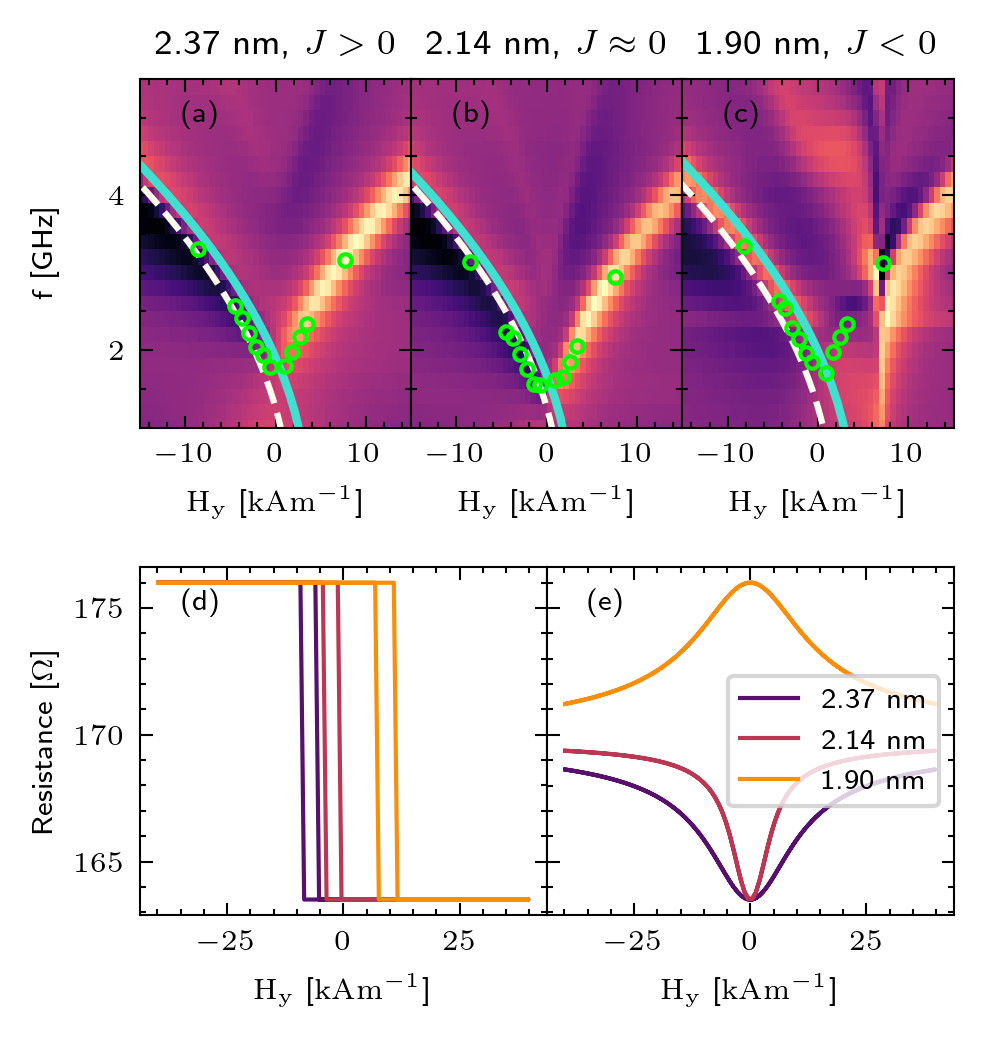

In [8]:
def kittel_relation(H_iec, H_ext, H_ku, Ms):
    B_ = (abs(H_iec) + H_ext + H_ku) * mu0
    f = 28024e6 * np.sqrt(B_ * (B_ + Ms))
    return f


df = pd.read_csv('./data/dispersion_relation.csv', skiprows=[0], sep=',')
df_magen_237 = pd.read_csv('./data/J237.dat', sep='\t', header=None)
df_magen_214 = pd.read_csv('./data/J214.dat', sep='\t', header=None)
df_magen_190 = pd.read_csv('./data/magen3190.dat', sep='\t', header=None)
cmap = sns.color_palette('inferno', len(loops0))
HJs = (25, 15, -29)
freq_indx = (4, 8, 14)
magens = [df_magen_237, df_magen_214, df_magen_190]
with plt.style.context(['science', 'nature']):
    fig = plt.figure(constrained_layout=True, figsize=(SINGLE_COL, 8), dpi=300)
    gs = plt.GridSpec(4, 6)
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:])
    axs = [ax1, ax2, ax3]
    ax4 = fig.add_subplot(gs[1, :3])
    ax5 = fig.add_subplot(gs[1, 3:])

    for i, th in enumerate(loops0):
        ax4.plot(loop_Hrange / 1e3,
                 loops0[th],
                 label=f"{th} nm",
                 color=cmap[i])
        ax5.plot(loop_Hrange / 1e3,
                 loops90[th],
                 label=f"{th} nm",
                 color=cmap[i])

    ax4.set_xlabel("$\mathrm{H}_\mathrm{y}$ [$\mathrm{kAm^{-1}}$]")
    ax5.set_xlabel("$\mathrm{H}_\mathrm{y}$ [$\mathrm{kAm^{-1}}$]")
    ax4.set_ylabel(r"Resistance [$\Omega$]")
    ax5.legend(frameon=True, loc=5)

    Ms = 1.03
    H_ku = 2 * 0.8e3 / (Ms)
    HJsAm = [H_  * OetoAm for H_ in HJs]
    Hpos_mask = np.argwhere(Hrange >= -10e3).flatten()
    for i, J in enumerate(Js):
        VSD2 = Filters.detrend_axis(VSD[i], 1)
        axs[i].pcolormesh(
            Hrange / 1e3,
            fscan / 1e9,
            VSD2,
            rasterized=True,
            shading='auto',
            cmap=cm.get_cmap("magma"),
        )
        krel = kittel_relation(HJsAm[i], Hrange[Hpos_mask], H_ku, Ms) / 1e9
        axs[i].plot(Hrange[~Hpos_mask] / 1e3, krel, color='turquoise', lw=2.)
        col = 'ivory'
        mult = 1
        if i == 2:
            colid = 11
            mult = -1.
        else:
            colid = 13
        axs[i].plot(mult * magens[i][0] / 1e3,
                    magens[i][colid] / 1e9,
                    label='Smit-Beljers',
                    lw=1.5,
                    linestyle='--',
                    color=col)

        if labels[i] + "nm" in df.columns:
            axs[i].plot(df[labels[i] + "nmH"] * OetoAm / 1e3,
                        df[labels[i] + "nm"],
                        '.',
                        markeredgecolor='lime',
                        markerfacecolor='none',
                        markersize=6,
                        mew=1)
        if J > 0:
            jlabel = r'$J > 0$'
        elif J < 0:
            jlabel = r'$J < 0$'
        if labels[i] == '2.14':
            jlabel = r'$J \approx 0$'
        axs[i].set_title(labels[i] + " nm, " + jlabel)
        axs[i].set_xlabel(r"$\mathrm{H}_\mathrm{y}$ [$\mathrm{kAm^{-1}}$]")
        axs[i].set_ylim([1, 5.5])
        axs[i].set_xlim([-15, 15])
        if i > 0:
            continue

    axs[0].set_ylabel(r"f [GHz]")
    for label, ax in zip(('(a)', '(b)', '(c)', '(d)', '(e)'),
                         (ax1, ax2, ax3, ax4, ax5)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    fig.subplots_adjust(wspace=0, hspace=0.4)

    for ax in (ax2, ax3, ax5):
        ax.set_yticklabels([])
    fig.align_ylabels()

    fig.savefig('figs-new/Fig3.eps')

## PIMM

In this experiment we will excite the system with a slight pulse of Oersted field in z direction. This simulates the experimental excitement by a current pulse along the y axis of the sample. The pulse should be very short and also rather weak, so that the system is not driven out of the harmonic regime. The pulse is applied at the beginning of the simulation and the system is allowed to relax to a steady state. The steady state is then used as initial condition for the next simulation. This is repeated for different pulse strengths. The resulting PIMM maps are shown below.

In [61]:
def simulate_pimm(J: float, stepsH: int = 100):
    int_step = 5e-13
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]

    Ku = 0.8e3
    alpha = 0.024  # 0.024
    Ms1 = 1.03
    Ms2 = 1.65
    surf = 0.1
    l1 = Layer(
        "free",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(0, 1., 0.),  # direction of the anisotropy
        Ms=Ms1,
        thickness=2e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)

    l2 = Layer(
        "bottom",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(1, 0, 0),  # direction of the anisotropy
        Ms=Ms2,
        thickness=6e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)
    j1 = Junction([l1, l2], 163.5, 176)
    j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(Ku))
    j1.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1e12))
    j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))
    spectrum = []
    Hscan, Hvecs = FieldScan.amplitude_scan(-800e3, 800e3, stepsH, 90, 45)
    div = 10
    j1.setLayerExternalFieldDriver(
        "all",
        AxialDriver(ScalarDriver.getConstantDriver(Hvecs[0][0]),
                    ScalarDriver.getConstantDriver(Hvecs[0][1]),
                    ScalarDriver.getConstantDriver(Hvecs[0][2])))
    j1.runSimulation(5e-9, int_step, int_step, solverMode=SolverMode.RK4)
    for hangle in Hvecs:
        j1.clearLog()
        j1.setLayerExternalFieldDriver(
            "all",
            AxialDriver(ScalarDriver.getConstantDriver(hangle[0]),
                        ScalarDriver.getConstantDriver(hangle[1]),
                        ScalarDriver.getConstantDriver(hangle[2])))
        HoeDriver = AxialDriver(
            NullDriver(), NullDriver(),
            ScalarDriver.getStepDriver(0, 50, 0.0, int_step * 5))
        j1.setLayerOerstedFieldDriver("all", HoeDriver)
        j1.runSimulation(15e-9, int_step, int_step, solverMode=SolverMode.RK4)
        log = j1.getLog()

        mixed = np.mean([
            np.asarray(log[f"{layer}_mz"]) * Ms
            for layer, Ms in zip(('free', 'bottom'), (Ms1, Ms2))
        ],
                        axis=0)
        mixed = np.squeeze(mixed)
        yf = np.abs(fft(mixed))
        frequencies = fftfreq(len(yf), int_step)
        frequencies = frequencies[:len(yf) // div]
        yf = yf[1:len(yf) // div]
        spectrum.append(yf)

    return np.asarray(spectrum), frequencies, Hscan


Jrange = np.linspace(-1e-3, 1e-3, 30)

data = defaultdict(list)
for J in tqdm(Jrange, desc="simulating J"):
    spectrum, frequencies, Hvecs = simulate_pimm(J)
    data['J'].append(J)
    data['spec'].append(spectrum)
    data['f'].append(frequencies)
    data['H'].append(Hvecs)

simulating J: 100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_2244/1025403050.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(Hvecs / 1e3,
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_2244/1025403050.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(Hvecs / 1e3,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support t

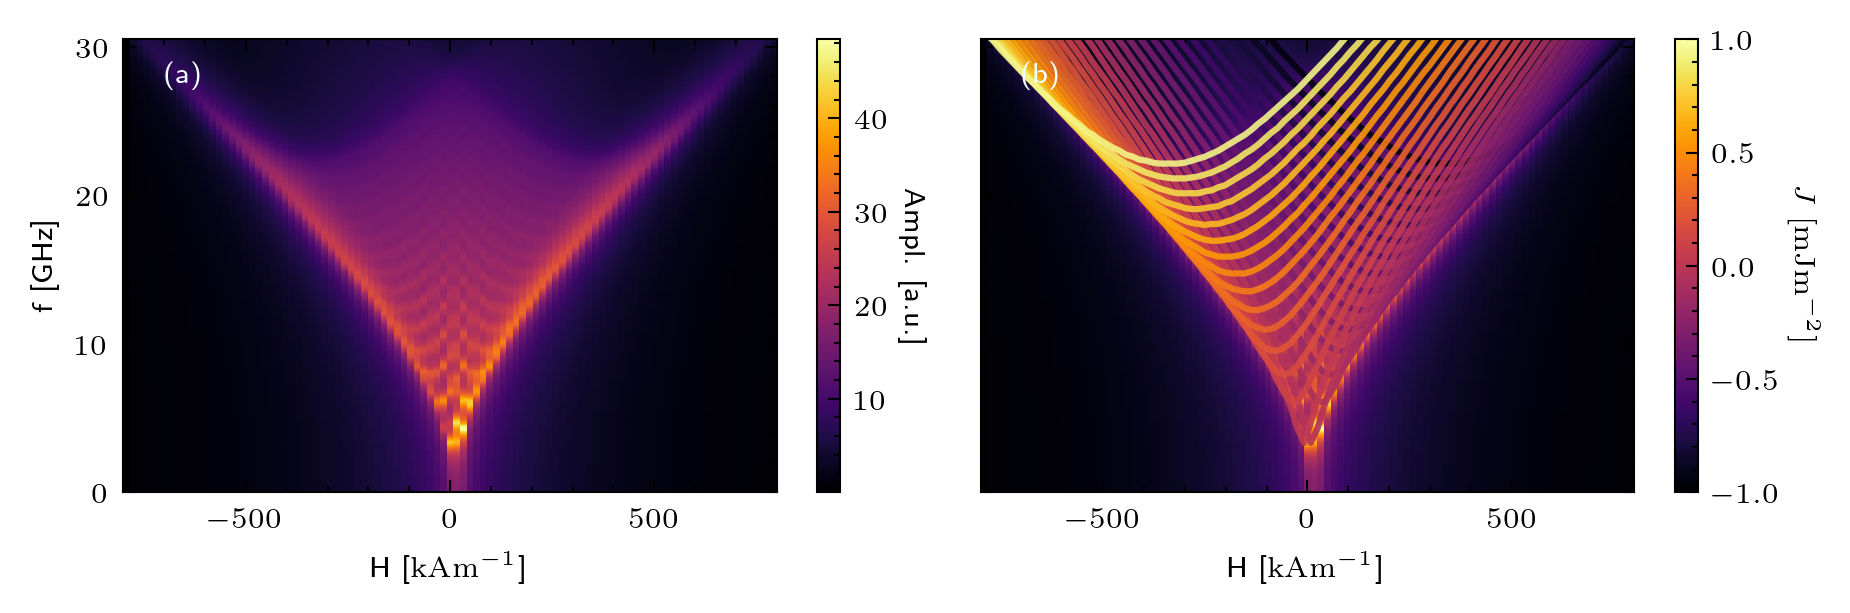

In [67]:
with plt.style.context(['science', 'nature']):
    fig, (ax1, ax2) = plt.subplots(1,
                                   2,
                                   figsize=(DOUBLE_COL, 2.),
                                    # figsize=(3.5, 2.5),
                                   sharey=True,
                                   dpi=300)
    ax2.set_ylim([0, 30.5])
    vmax = max(spectrum.max(), spectrum.min())
    # argmaxline
    lw = 1.5
    palette = sns.color_palette("inferno", len(Jrange))
    spectrum = np.zeros_like(data['spec'][0])
    for i in range(Jrange.shape[0]):
        max_freqs = np.argmax(data['spec'][i], axis=1)
        ax2.plot(data['H'][0] / 1e3,
                 data['f'][0][max_freqs] / 1e9,
                 linewidth=lw,
                 color=palette[i],
                 alpha=.9)
        spectrum += data['spec'][i]
    ax2.pcolormesh(Hvecs / 1e3,
               frequencies / 1e9,
               spectrum.T,
               rasterized=True,
               shading='auto',
               cmap='inferno')
    ax2.set_xlabel(r"H  [$\mathrm{kAm^{-1}}$]")
    ax1.set_xlabel(r"H  [$\mathrm{kAm^{-1}}$]")
    ax1.set_ylabel("f [GHz]")
    ax1.set_ylim([0, 30.5])
    ax1.pcolormesh(Hvecs / 1e3,
               frequencies / 1e9,
               spectrum.T,
               rasterized=True,
               shading='auto',
               cmap='inferno')

    cmap = sns.color_palette("inferno", as_cmap=True)
    cmap = sns.color_palette("inferno", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=spectrum.min(), vmax=spectrum.max())
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=ax1,
                        orientation='vertical')
    cbar.ax.set_ylabel(r"Ampl. [a.u.]", rotation=270,)
    cbar.ax.get_yaxis().labelpad = 9.5
    cmap = sns.color_palette("inferno", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=Jrange.min() * 1e3,
                                vmax=Jrange.max() * 1e3)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=ax2,
                        # rasterized=True,
                        orientation='vertical')
    cbar.ax.set_ylabel(r"$J \ [\mathrm{mJm^{-2}}]$",
                       rotation=270)
    cbar.ax.get_yaxis().labelpad = 9.5

    fig.subplots_adjust(wspace=0.05)
    for label, ax in zip(('(a)', '(b)'), (ax1, ax2)):
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)

        fc = 'none'
        ec = 'none'
        ax.text(0,
                1,
                label,
                color='azure',
                transform=ax.transAxes + trans,
                verticalalignment='top',
                bbox=dict(facecolor=fc, edgecolor=ec, pad=3.0))
    fig.savefig("figs-new/Fig5.eps")

## CIMS
In this section we focus on generating switching currents. We are going to excite the system with a range of different pulse strengths. In this case, unlike in the PIMM, we excite the system directly with the current density pulse (which takes on the form of trapezoidal impulse) in order to evoke the torque response. After each simulation the system is allowed to relax to a steady state. We then pick up the steady state to see in which state (up/down) the magnetisation has settled. Based on the change of the hysteresis change, we can infer the critical current for a given value of the external field.

In [24]:
def simulate_cims(H_ext: float, impulses: np.ndarray):
    w = 10e-6
    l = 75e-6

    Ms = 0.5
    Hk = 2508 * OetoAm
    K = Ms * Hk / 2
    jden = 6.94e10
    Hdl = 6.23e2 / jden * 1.35
    Hfl = 1.43e2 / jden * 1.35
    # surface is required for temperature calculation
    surf = w * l
    # approximate demagnetisation tensor
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 0)]
    ### Create MTJ ###
    # we use the .createSTTLayer to indicate the STT contributions
    # we can also create SOT layers for other experiments.
    alpha = 0.03
    l1 = Layer.createSOTLayer(
        "free",
        mag=CVector(0.1, 0.1, 1.),
        anis=CVector(0, 0., 1.),  # direction of the anisotropy
        Ms=Ms,
        thickness=4e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha,
        dampingLikeTorque=Hdl,
        fieldLikeTorque=Hfl)

    j = Junction([l1])
    j.setLayerAnisotropyDriver("all", ScalarDriver.getConstantDriver(K))
    j.setLayerReferenceLayer("all", CVector(0, 1, 0))

    tstep = 1e-13

    hysteresis = []
    data = {}

    hangle = FieldScan.angle2vector(90, 0, H_ext)
    j.setLayerExternalFieldDriver(
        "free",
        AxialDriver(ScalarDriver.getConstantDriver(hangle.x),
                    ScalarDriver.getConstantDriver(hangle.y),
                    ScalarDriver.getConstantDriver(hangle.z)))
    for current in impulses:
        j.clearLog()
        j.setLayerMagnetisation("free", CVector(0, 0, 1))
        pulse = ScalarDriver.getTrapezoidDriver(0, current, 0, 1e-9, 3e-9)
        j.setLayerCurrentDriver("all", pulse)
        j.runSimulation(15e-9, tstep, tstep)

        log = j.getLog()
        str_ = "free"
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]])
        Rx0 = [100]
        Ry0 = [1]
        SMR = [1.11]
        AMR = [0.41]
        AHE = [2.23]
        _, Rxy = calculate_resistance_series(Rx0,
                                             Ry0,
                                             AMR=AMR,
                                             AHE=AHE,
                                             SMR=SMR,
                                             m=m,
                                             l=[l],
                                             w=[w])

        Rstable = Rxy[-100:].mean()
        hysteresis.append(Rstable)

    data['hysteresis'] = hysteresis
    critical_current = 0
    for i in range(1, len(hysteresis)):
        if abs(hysteresis[i] - hysteresis[i - 1]) > 0.1:
            critical_current = impulses[i]
    data['critical_current'] = critical_current
    return data


Hspace = np.linspace(-1200, 1200, 50, endpoint=True) * OetoAm
Imax = 1.4e13
impulses = np.linspace(-Imax, Imax, num=250)


def sim_warp(H_ext):
    return simulate_cims(H_ext, impulses)


critical_currents = np.zeros(len(Hspace))

for res in distribute(sim_warp, [Hspace]):
    indx, output = res
    critical_currents[indx] = output['critical_current']

# uncomment for serial
# import time
# start = time.time()
# for i, H_ext in enumerate(tqdm(Hspace)):
#     output = sim_warp(H_ext)
#     critical_currents[i] = output['critical_current']
#     # print(f'{i} / {len(Hspace)}')
# end = time.time()
# print(f'Elapsed time: {end - start}')

100%|██████████| 50/50 [03:03<00:00,  3.67s/it]


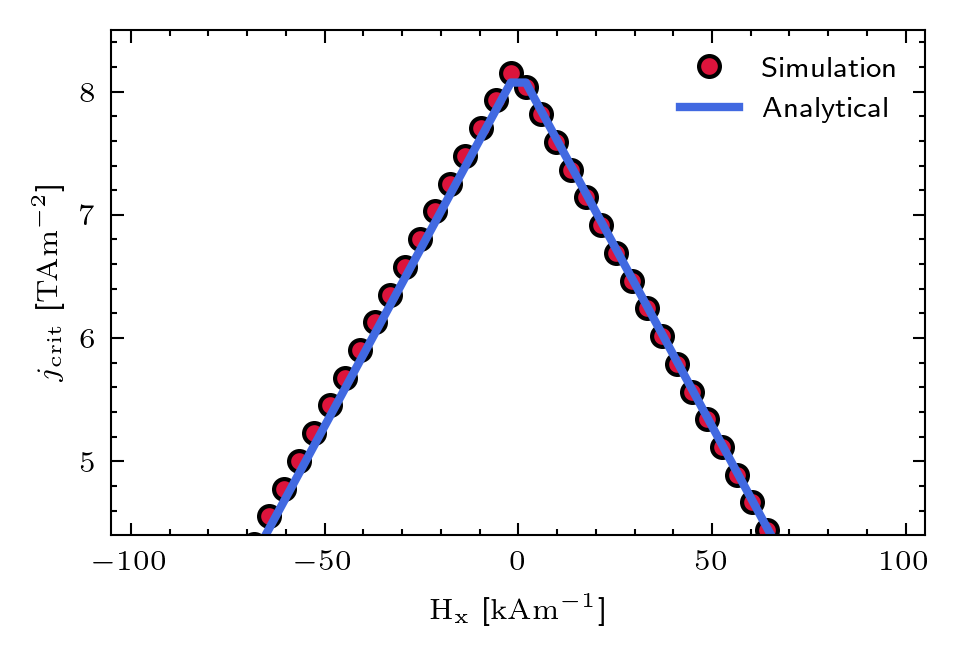

In [59]:
def compute_j(Hx):
    Hk = 2508 * OetoAm
    Ms = 0.5
    thetaSH = 13.5
    tfm = 4e-9
    jc = -(2 * echarge * Ms * tfm / hbar * thetaSH) * (Hk / 2 -
                                                      Hx / math.sqrt(2))
    return jc


cric_c = compute_j(Hx=np.abs(Hspace))
ratio = 4.8/6.4
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL * RATIO * 0.85), dpi=300)
    ax.set_ylim([4.4, 8.5])
    #     ax.set_xlim([-75, 75])
    ax.plot(Hspace / 1e3,
            np.abs(critical_currents) / 1e12,
            'o',
            markersize=5,
            label='Simulation',
            color='crimson',
            markeredgecolor='k')
    ax.plot(Hspace / 1e3,
            cric_c / 1e12,
            lw=2,
            label='Analytical',
            color='royalblue')
    ax.set_xlabel(r"$\mathrm{H}_\mathrm{x}$ [$\mathrm{kAm^{-1}}$]")
    ax.set_ylabel(r"$j_\mathrm{crit}$ [$\mathrm{TAm^{-2}}$]")

    ax.legend()
    fig.savefig("figs-new/Fig7.eps")

## M(H) and R(H) loops

Here we will generate the M(H) and R(H) loops for the system. We will use the same method as in the PIMM section. We will then apply a range of different external fields and record the magnetisation and the resistance at a steady state. This shows that the PIMM, M(H) and R(H) may be collected from the same range of simulations!

In [28]:
# approximate demagnetisation tensor
demag = [
    CVector(0.00116298, 0, 0),
    CVector(0, 0.000227086, 0),
    CVector(0, 0, 0.99861)
]
alpha = 0.005
Kdir = CVector(1, 0, 0)
Ms = 1.65
# Ms = 1.8
l1 = Layer("free",
           mag=CVector(0, 0, 1),
           anis=Kdir,
           Ms=Ms,
           thickness=3.99e-9,
           cellSurface=0,
           demagTensor=demag,
           damping=alpha)

l2 = Layer("bottom",
           mag=CVector(0, 0, 1),
           anis=Kdir,
           Ms=Ms,
           thickness=4e-9,
           cellSurface=0,
           demagTensor=demag,
           damping=alpha)
# J1 = -1.78e-3
# J2 = -1.69e-4
J1 = -1.8e-3
J2 = -1.74e-4

K1 = K2 = 1.05e3
# K1 = K2 = 0.55e3
int_step = 4e-14

j1 = Junction([l1, l2], 100, 102)

j1.setLayerAnisotropyDriver("all", ScalarDriver.getConstantDriver(K1))
j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J1))
j1.setQuadIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J2))
Hscan, Hvecs = FieldScan.amplitude_scan(-1200e3, 1200e3, 200, 89, 90)
magnetisations = defaultdict(list)
spectrum = []
sim_time = 4e-9
for indx, H in enumerate(tqdm(Hvecs)):
    j1.clearLog()
    j1.setLayerExternalFieldDriver(
        "all",
        AxialDriver(ScalarDriver.getConstantDriver(H[0]),
                    ScalarDriver.getConstantDriver(H[1]),
                    ScalarDriver.getConstantDriver(H[2])))
    j1.setLayerOerstedFieldDriver(
        "all",
        AxialDriver(NullDriver(), NullDriver(),
                    ScalarDriver.getStepDriver(0, 50, 0, int_step * 3)))
    # if (H)
    j1.runSimulation(sim_time, int_step, int_step)
    log = j1.getLog()

    org_layer_strs = ('free', 'bottom')
    m_traj = np.asarray([[
        log[f'{org_layer_strs[i]}_mx'], log[f'{org_layer_strs[i]}_my'],
        log[f'{org_layer_strs[i]}_mz']
    ] for i in range(2)])

    m = m_traj[:, :, -100:]  # all layers, all x, y, z, last timestamp
    m_avg = np.mean(m_traj[:, :, -1], 0)

    mixed = [np.asarray(log[f"{org_layer_strs[i]}_mz"]) for i in range(2)]
    # mixed = np.mean(np.squeeze(mixed), axis=0)
    yf = np.abs(
        fft(log[f"{org_layer_strs[0]}_mz"]) +
        fft(log[f"{org_layer_strs[1]}_mz"]))
    freqs = fftfreq(len(yf), int_step)
    freqs = freqs[:len(freqs) // 2]
    yf = yf[:len(yf) // 2]

    findx = np.argwhere(freqs <= 65e9)
    freqs = freqs[findx]
    yf = yf[findx]

    spectrum.append(yf)
    Rx, Ry = calculate_resistance_series([100, 100], [1, 1], [-0.046, -0.046],
                                         [-2.7, -2.7], [-0.24, -0.24],
                                         m,
                                         l=[30, 30],
                                         w=[20, 20])
    magnetisations['H'].append(Hscan[indx])
    magnetisations['m1'].append(m[0].mean(axis=1))
    magnetisations['m2'].append(m[1].mean(axis=1))
    magnetisations['m'].append(m_avg)
    magnetisations['Rxx'].append(Rx.mean())
    magnetisations['Rxy'].append(Ry.mean())
    magnetisations['Rz'].append(log['R_free_bottom'][-1])
    magnetisations['traj'].append(m_traj)

spectrum = np.asarray(spectrum).squeeze()

# phase computation
traj = np.asarray(magnetisations['traj'])
time = np.asarray(log['time']) * 1e9
start = 3.5  # pick a time
stop = 4.5
phases = defaultdict(list)
indx = 1
for traj_h in traj:
    eps = np.deg2rad(0.01)  # we allow 5 deg variation
    rtime = np.argwhere((time <= stop) & (time >= start))
    for label, indx in zip('xyz', range(3)):
        a = traj_h[0, indx, rtime].squeeze()
        b = traj_h[1, indx, rtime].squeeze()
        af = fft(a)
        bf = fft(b)
        freqs2 = fftfreq(len(af), int_step)
        freqs2 = freqs2[:len(freqs2) // 2]
        af = af[:len(af) // 2]
        bf = bf[:len(bf) // 2]

        findx = np.argwhere(freqs2 <= 65e9)
        af = af[findx]
        bf = bf[findx]

        angle_af = np.angle(af)
        angle_bf = np.angle(bf)
        max_freq = np.argmax(np.abs(af[1:]))
        phase = np.abs(angle_af[1:][max_freq] - angle_bf[1:][max_freq])
        phases[label].append(phase)

100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


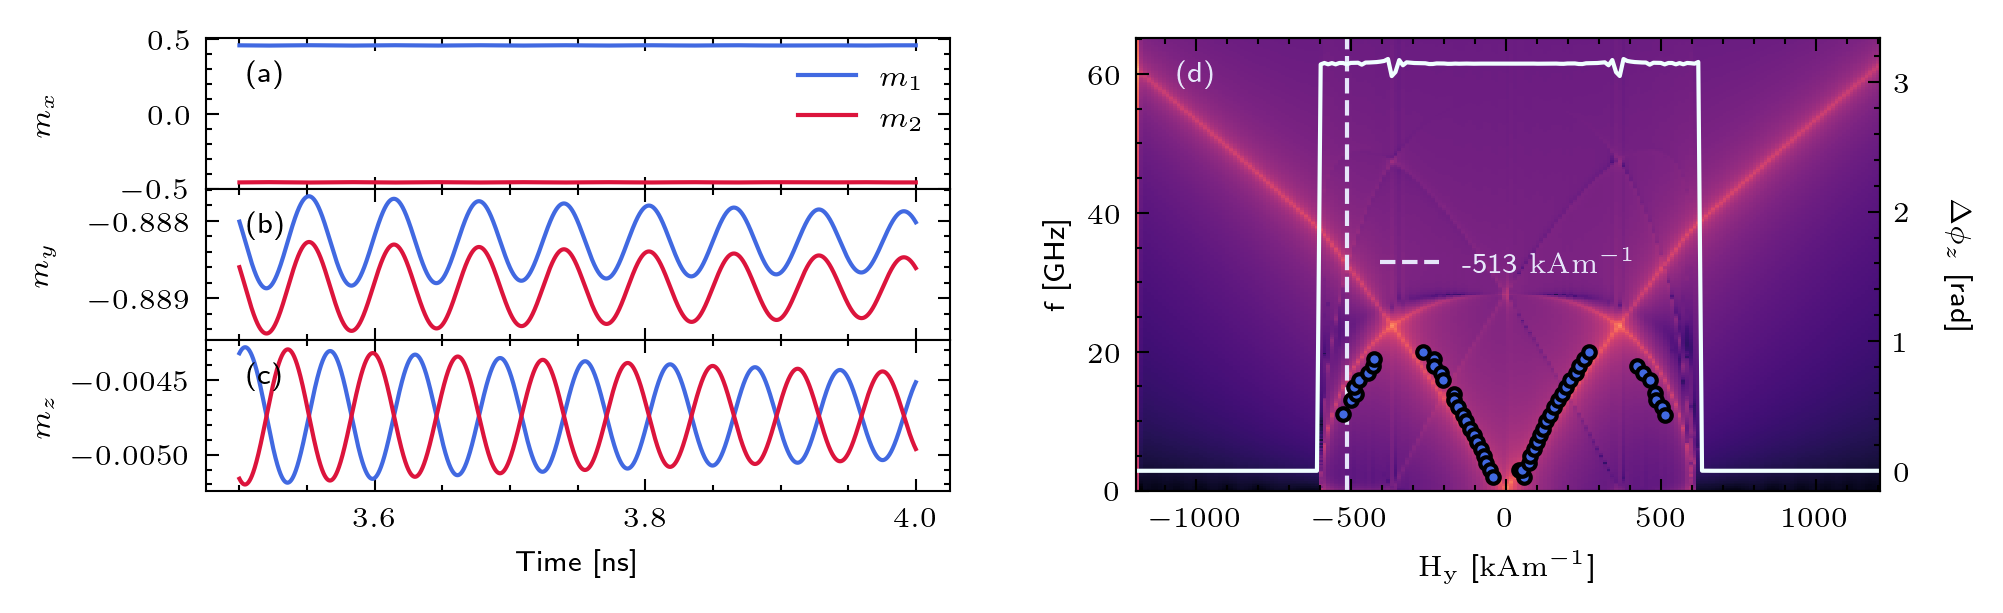

In [30]:
pimm_data = pd.read_csv('./data/4804_35.csv', sep=';')
pimm_data['f'] = pd.to_numeric(pimm_data['f'].str.replace(',',
                                                          '.')).astype(float)
pimm_data['H'] = pd.to_numeric(pimm_data['H'].str.replace(',',
                                                          '.')).astype(float)
pimm_data = pimm_data.loc[pimm_data['H'].between(-550e3 / OetoAm,
                                                 550e3 / OetoAm)]
with plt.style.context(['science', 'nature']):
    fig, axs = plt.subplots(3, 2, figsize=(DOUBLE_COL, 2.), dpi=300, sharex=True)
    # hindx = 55
    hindx = 57
    traj = np.asarray(magnetisations['traj'])[hindx]
    time = np.asarray(log['time']) * 1e9
    start = 3.5
    stop = 4.5
    rtime = np.argwhere((time <= stop) & (time >= start))
    for i, label in enumerate('xyz'):
        axs[i, 0].plot(time[rtime],
                       traj[0, i, rtime],
                       color='royalblue',
                       label=rf"$m_1$")
        axs[i, 0].plot(time[rtime],
                       traj[1, i, rtime],
                       color='crimson',
                       label=rf"$m_2$")
        axs[i, 0].set_ylabel(rf'$m_{label}$')
    fig.subplots_adjust(hspace=0, wspace=0.25)
    fig.align_labels()

    gs = axs[1, -1].get_gridspec()
    axs[0, 0].legend()
    axbig = fig.add_subplot(gs[:, -1])
    axbig.pcolormesh(Hscan[1:] / 1e3,
                 freqs / 1e9,
                 np.log10(spectrum[1:].T),
                 shading='auto',
                 rasterized=True,
                 cmap='magma')
    axbig.axvline(x=Hscan[hindx] / 1e3,
                  color='lavender',
                  linestyle='--',
                  label=f"{Hscan[hindx] / 1e3:.0f}"" $\mathrm{kAm^{-1}}$")
    axbig.set_xlabel("$\mathrm{H}_\mathrm{y}$ [$\mathrm{kAm^{-1}}$]")
    axbig.set_ylabel("f [GHz]")
    axbig2 = axbig.twinx()
    axbig.plot(pimm_data['H'] * OetoAm / 1e3,
               pimm_data['f'],
               'o',
               markerfacecolor='royalblue',
               markeredgecolor='black')
    p = uniform_filter1d(phases['z'][1:], 5)

    axbig2.plot(Hscan[1:] / 1e3, p, color='azure', label=rf'$\phi_{label}$')
    axbig2.set_ylabel(r'$\Delta\phi_z$ [rad]', rotation=270, labelpad=15)

    for ax in axs[:, -1]:
        # ax.remove()
        ax.set_axis_off()
    axs[-1, 0].set_xlabel("Time [ns]")
    axbig.legend(frameon=False, labelcolor='lavender', loc=10)
    # axbig.legend(frameon=False, labelcolor='lavender', loc=1, fontsize='x-small')
    for label, ax in zip(('(a)', '(b)', '(c)', '(d)'), [*axs[:, 0], axbig]):
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        if label == '(d)':
            fc = 'none'
            ec = 'none'
            color='lavender'
        else:
            fc = 'none'
            ec = 'none'
            color='black'
        ax.text(0,
                1,
                label,
                color=color,
                transform=ax.transAxes + trans,
                verticalalignment='top',
                bbox=dict(facecolor=fc, edgecolor=ec, pad=3.0))
    fig.savefig('figs-new/Fig3.eps')

No handles with labels found to put in legend.


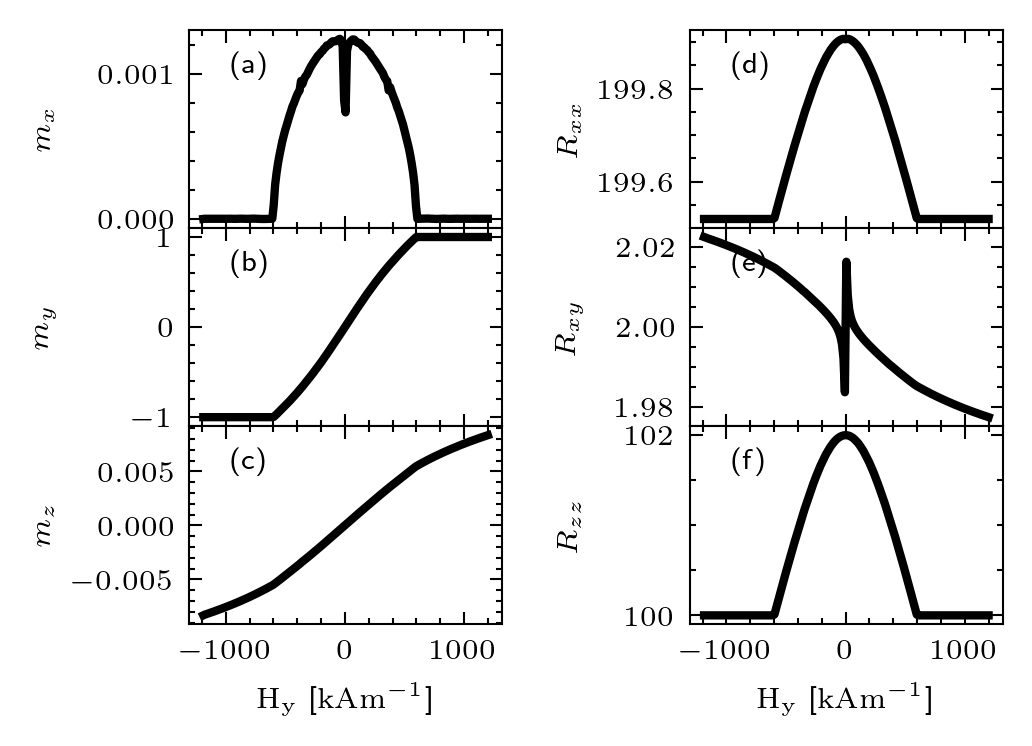

In [35]:
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(3, 2, 
                            figsize=(SINGLE_COL, SINGLE_COL*RATIO),
                           dpi=300, sharex=True)
    m1 = np.asarray(magnetisations['m1'])
    m2 = np.asarray(magnetisations['m2'])
    Rx = np.asarray(magnetisations['Rxx'])
    Ry = np.asarray(magnetisations['Rxy'])
    Rz = np.asarray(magnetisations['Rz'])
    m = np.asarray(magnetisations['m'])
    H = np.asarray(magnetisations['H']) / 1e3
    w = 3
    for label, i in zip('xyz', range(3)):
        ax[i, 0].plot(H[1:], m[1:, i], lw=2, color='k', alpha=1)
        ax[i, 0].set_ylabel(rf"$m_{label}$")

    ax[0, 0].legend()
    for i, (label, R) in enumerate(zip(('xx', 'xy', 'zz'), (Rx, Ry, Rz))):
        ax[i, 1].plot(H[1:], R[1:], lw=2, color='k')
        ax[i, 1].set_ylabel(r"$R_{" f"{label}" r"}$")
    fig.subplots_adjust(wspace=0.6, hspace=0)
    fig.align_ylabels()
    ax[-1, 0].set_xlabel("$\mathrm{H}_\mathrm{y}$ [$\mathrm{kAm^{-1}}$]")
    ax[-1, 1].set_xlabel("$\mathrm{H}_\mathrm{y}$ [$\mathrm{kAm^{-1}}$]")
    for label, ax in zip(('(a)', '(d)', '(b)', '(e)', '(c)', '(f)'),
                         ax.flatten()):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
        
    fig.savefig('figs-new/Fig4.eps')

## Angular harmonics

Here, we can simulate a system where we can analyse the influence of damping like and field like torques. The sweep is now with the angle of the field (in-plane angle) and not its magnitude.


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


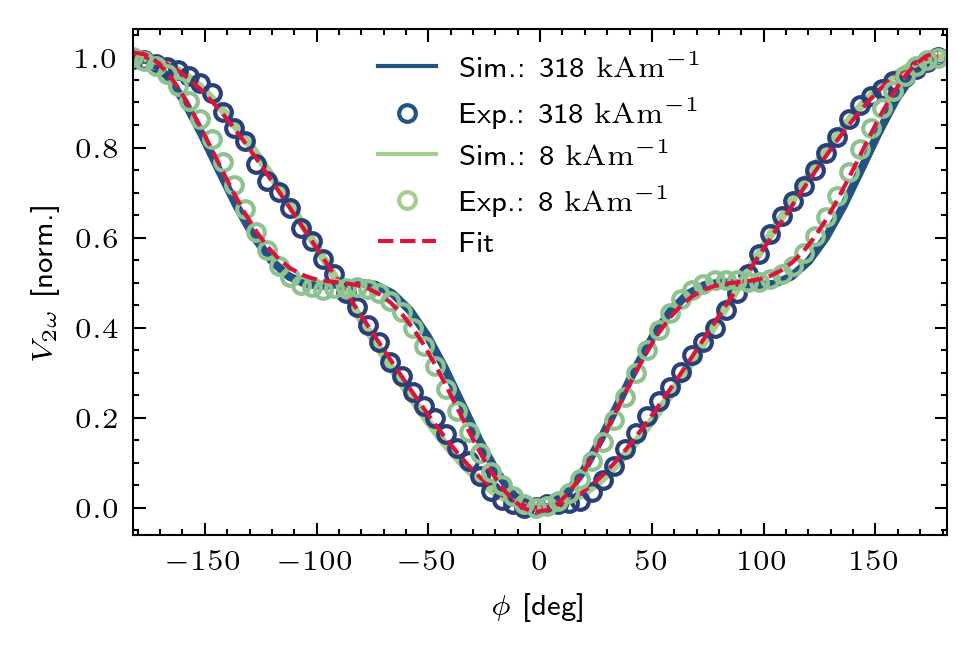

In [68]:
data = pd.read_csv('./data/V10325_Ptb_85_thin_cross.txt',
                   sep='\t',
                   skiprows=[1, 2])
Hrange = np.arange(100, 5000, 100)
Hrange_red = [4000., 100.]
jhm = 1.33e11
l = 3e-5
w = 1e-5
rhohm = 2.5e-7
rhofm = 2.5e-7
thm = 9.9e-9
tfm = 2e-9
ahm = thm * w
afm = tfm * w
Rhm = rhohm * l / ahm
Rfm = rhofm * l / afm
Irf = jhm * ahm

R0 = 1
Rx0 = [0]
Ry0 = [3]
SMR = [-0.125 * R0]
AMR = [-1e-4 * R0]
AHE = [1.36]
w = [w]
l = [l]


def compute_vsd(dynamic_r, integration_step, dynamic_i):
    SD = dynamic_i * dynamic_r
    y = fft(SD) * (2 / len(SD))
    amp = np.abs(y)
    phase = np.angle(y)
    freqs = fftfreq(len(y), integration_step)
    y = y[:len(y) // 2]
    freqs = freqs[:len(freqs) // 2]
    return amp, phase, freqs


def find_max_f_frequency(freqs: np.ndarray, values: np.ndarray,
                         frequency: float):
    # take between 0 and max
    freq_indx = np.abs(freqs - frequency).argmin()
    max_value = values[freq_indx]
    max_freq = freqs[freq_indx]
    return max_value, max_freq


def compute_harmonics(theta, Hampl, Ms, Ku, Hdl, Hfl, steps):

    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1.)
    ]

    thickness = 2e-9
    s_time = 200e-9
    int_step = 1e-12

    l1_params = {
        "Ms": Ms,
        "thickness": thickness,
        "anis": CVector(0.1, 0.1, 1.),
        "mag": CVector(0, 0, 1.),
        "cellSurface": 1.0,
        "demagTensor": demagTensor,
        "damping": 0.003,
    }
    l1 = Layer(id="free", **l1_params)
    l1.setReferenceLayer(CVector(0., 1., 0.))
    layer_str = ["free"]
    layers = [l1]
    junction = Junction(layers=layers)
    junction.setLayerAnisotropyDriver("all",
                                      ScalarDriver.getConstantDriver(Ku))

    frequency = 0.01e9
    Hscan, Hvecs = FieldScan.phi_scan(-190, 190, steps, Hampl, theta=theta)
    amp_diag1f = np.zeros((len(Hscan), ))
    phase_diag2f = np.zeros((len(Hscan), ))
    junction.setLayerDampingLikeTorqueDriver(
        "all", ScalarDriver.getSineDriver(0, Hdl, frequency, 0))
    junction.setLayerFieldLikeTorqueDriver(
        "all", ScalarDriver.getSineDriver(0, Hfl, frequency, 0))

    Hval = Hvecs[0]

    HDriver = AxialDriver(ScalarDriver.getConstantDriver(Hval[0]),
                          ScalarDriver.getConstantDriver(Hval[1]),
                          ScalarDriver.getConstantDriver(Hval[2]))
    junction.runSimulation(s_time, int_step, int_step)
    mags = [junction.getLayerMagnetisation("free")]
    for hi, Hval in enumerate(Hvecs):
        junction.clearLog()
        HDriver = AxialDriver(ScalarDriver.getConstantDriver(Hval[0]),
                              ScalarDriver.getConstantDriver(Hval[1]),
                              ScalarDriver.getConstantDriver(Hval[2]))
        junction.setLayerExternalFieldDriver("all", HDriver)
        # set mags for better convergence
        for i, l_str in enumerate(layer_str):
            junction.setLayerMagnetisation(l_str, mags[i])

        junction.runSimulation(s_time, int_step, int_step)
        # set new mags
        for str_ in layer_str:
            mags[i] = junction.getLayerMagnetisation(str_)

        log = junction.getLog()
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]
             for str_ in layer_str])

        _, dynamic_ry = calculate_resistance_parallel(Rx0, Ry0, AMR, AHE, SMR,
                                                      m, l, w)

        lt = np.asarray(log['time'])
        dynamic_i = Irf * np.sin(2 * np.pi * frequency * lt)
        org_amp, org_phase, freqs_org = compute_vsd(dynamic_r=dynamic_ry,
                                                    integration_step=int_step,
                                                    dynamic_i=dynamic_i)

        max_phase2f, _ = find_max_f_frequency(freqs_org, org_phase,
                                              2 * frequency)
        max_amp1f, _ = find_max_f_frequency(freqs_org, org_amp, frequency)
        max_amp2f, _ = find_max_f_frequency(freqs_org, org_amp, 2 * frequency)
        amp_diag1f[hi] = max_amp1f
        phase_diag2f[hi] = np.cos(max_phase2f) * max_amp2f
    return amp_diag1f, phase_diag2f, Hscan


def compute_harmonics_distributed(H):
    """Insert layer parameters here"""
    theta = 92
    Ms = 1.2
    Ku = 0.00313 * TtoAm * Ms / 2
    Hdl = 1.325e-3 * TtoAm
    Hfl = -2.06e-04 * TtoAm
    _, phase_diag2f, phi_scan = compute_harmonics(theta=theta,
                                                  steps=50,
                                                  Ms=Ms,
                                                  Ku=Ku,
                                                  Hampl=H * OetoAm,
                                                  Hdl=Hdl,
                                                  Hfl=Hfl)
    return phase_diag2f, phi_scan


# we distribute over all fields
result = distribute(compute_harmonics_distributed, [Hrange_red], n_cores=2)

res = []
for r in result:
    (i), out = r
    phase_diag2f, scan = out
    res.append(phase_diag2f)
    phi_scan = scan

res_max = np.max(res)
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300,
                           figsize=(SINGLE_COL, SINGLE_COL * RATIO * 0.85))
    ms = 8
    cmap = sns.color_palette("crest", as_cmap=True)
    cmap_disc = sns.color_palette("crest", len(Hrange))
    norm = mpl.colors.Normalize(vmin=min(Hrange / 1e3), vmax=max(Hrange / 1e3))
    indx = (2, 10)
    patches = []
    labels = []
    for i in range(len(res)):
        r = np.asarray(res[i])
        R = (r - r.min()) / (r.max() - r.min())
        ax.plot(phi_scan,
                R,
                lw=2,
                color=cmap(norm(Hrange_red[i] / 1e3)),
                label="Sim.")
        labels.append(f"Sim.: {np.round(Hrange_red[i]*OetoAm/1e3):.0f} "
                      r"$\mathrm{kAm^{-1}}$")
        line_exp = Line2D(range(1),
                          range(1),
                          color=cmap(norm(Hrange_red[i] / 1e3)))

        patches.append(line_exp)
        patches.append(
            Line2D([], [],
                   linestyle='none',
                   color=cmap(norm(Hrange_red[i] / 1e3)),
                   marker='o',
                   markerfacecolor='none',
                   markersize=ms // 2))
        labels.append(f"Exp.: {np.round(Hrange_red[i]*OetoAm/1e3):.0f} "
                      r"$\mathrm{kAm^{-1}}$")
    patches.append(
        Line2D(range(1), range(1), linestyle='dashed', color="crimson"))
    labels.append("Fit")

    for i in indx:
        V = (data[f'Phase.{i}'] /
             data[f'Phase.{i}'].max()).rolling(window=5).mean()
        V = (V - V.min()) / (V.max() - V.min())
        # remove NaNs
        x = data[f'F. Angle Azim..{i}'] - 12
        mask = pd.isna(V)
        x = x.loc[~mask]
        V = V.loc[~mask]
        ax.plot(x,
                V,
                '.',
                markersize=ms,
                markerfacecolor='none',
                markeredgecolor=cmap(norm(data[f'Field.{i}'][0] / 1e3)),
                label='Exp.')

        popt, _ = curve_fit(
            f=meinert_model,
            xdata=x,
            ydata=V,
        )
        ax.plot(x, meinert_model(x, *popt), '--', color='crimson', label='Fit')

    ax.set_xlim([-182, 182])

    ax.legend(handles=patches, labels=labels)
    ax.set_xlabel(r"$\phi$ [deg]")
    ax.set_ylabel(r"$V_{2\omega}$ [norm.]")
    loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    fig.savefig("figs-new/Fig6.eps")

## Stack system
In this section we will simulate a simple parallel structure of two MTJs. We are interested in how the two magnetic tunnel junctions will synchronised if we couple them electrically. Here, we use some example electrical coupling (via the current) values and we scan over the external field values, at a constant current density value. You could easily try to scan with the current density instead of the external field and see how the system behaves then.

In [55]:
damping = 0.005
Ms = 1.6
thickness = 1.8e-9
SLP = 0.69
beta = 1
spin_polarisation = 1.
surf = 70e-9 * 70e-9 * np.pi
demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
### Create MTJ ###
# we use the .createSTTLayer to indicate the STT contributions
# we can also create SOT layers for other experiments.
l1 = Layer.createSTTLayer("free",
                          mag=CVector(0, 0, .9),
                          anis=CVector(0, 0, 1),
                          Ms=Ms,
                          thickness=thickness,
                          cellSurface=surf,
                          demagTensor=demag,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=SLP,
                          beta=beta,
                          spinPolarisation=spin_polarisation)
l2 = Layer.createSTTLayer("free",
                          mag=CVector(0, 0, 1),
                          anis=CVector(0., 0., 1),
                          Ms=Ms * 1.11,
                          thickness=thickness,
                          cellSurface=surf,
                          demagTensor=demag,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=SLP,
                          beta=beta,
                          spinPolarisation=spin_polarisation)

# we use pinning layers for the bottom layer
l1.setReferenceLayer(CVector(1, 0, 0))
l2.setReferenceLayer(CVector(1, 0, 0))

j1 = Junction([l1], 100, 200)
j2 = Junction([l2], 110, 220)
j1.setLayerAlternativeSTT("all", True)
j2.setLayerAlternativeSTT("all", True)
j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(7e4))
j2.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(10e4))
stack = ParallelStack([j1, j2])

int_time = 1e-12
sim_time = 100e-9
stack.setCoupledCurrentDriver(ScalarDriver.getConstantDriver(6e10))

k = 20
Hspan, Hrange = FieldScan.amplitude_scan(-100e3, 400e3, 100, 5, 0)
couplings = defaultdict(list)
for label, coupling in zip(('pos', 'zero', 'neg'), (0.1, 0, -0.12)):
    stack.setCouplingStrength(coupling)
    spectrum = []
    for Hvector in tqdm(Hrange):
        stack.clearLogs()
        stack.setExternalFieldDriver(
            AxialDriver(ScalarDriver.getConstantDriver(Hvector[0]),
                        ScalarDriver.getConstantDriver(Hvector[1]),
                        ScalarDriver.getConstantDriver(Hvector[2])))
        stack.runSimulation(sim_time, int_time, int_time)

        log = stack.getLog()
        y = fft(log['Resistance'])
        yk = np.abs(y[:len(y) // k])
        spectrum.append(yk)

        if label == 'neg':
            log0 = stack.getLog(0)
            log1 = stack.getLog(1)
            fft1 = fft(log0['R'])
            freqs = fftfreq(len(fft1), d=int_time)
            freqs = freqs[1:len(freqs) // k]
            fft1 = fft1[1:len(fft1) // k]
            fft2 = fft(log1['R'])
            fft2 = fft2[1:len(fft2) // k]
            amp1 = np.abs(fft1)
            amp2 = np.abs(fft2)
            fmax1 = np.argmax(amp1)
            fmax2 = np.argmax(amp2)
            phase1 = np.angle(fft1)[fmax1]
            phase2 = np.angle(fft2)[fmax2]

            couplings['resonance1'].append(freqs[fmax1])
            couplings['resonance2'].append(freqs[fmax2])

    spectrum = np.asarray(spectrum)
    spectrum = uniform_filter(spectrum, size=7)
    freqs = fftfreq(len(y), d=int_time)
    freqs = freqs[:len(freqs) // k]
    couplings[f'{label}_freqs'] = freqs
    couplings[f'{label}_spectrum'] = spectrum

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


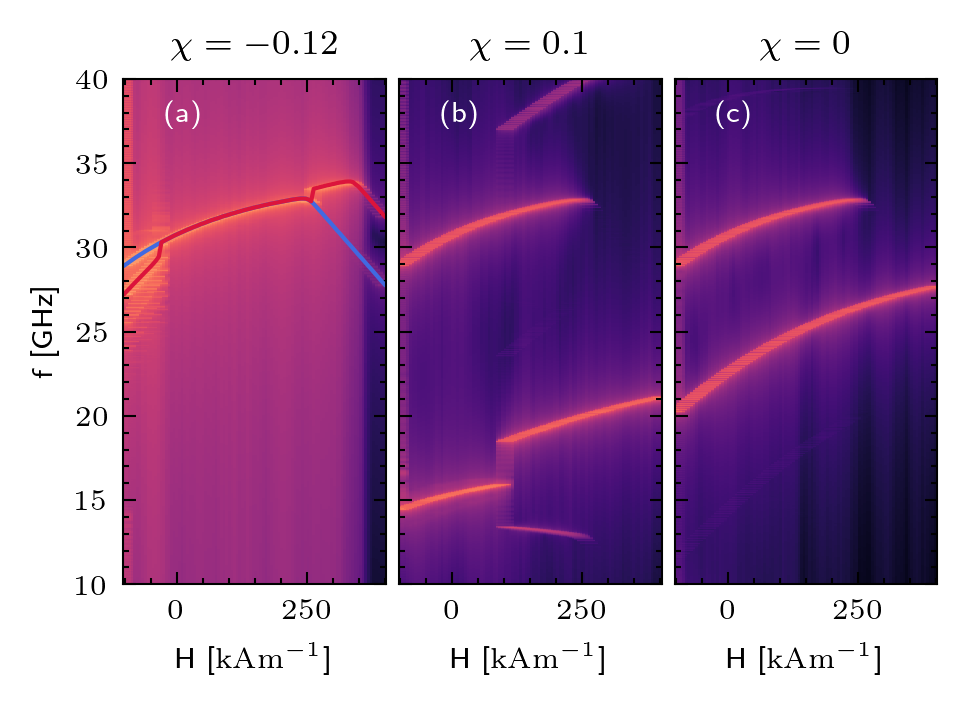

: 

In [70]:
cmap = sns.color_palette("magma", as_cmap=True)
with plt.style.context(['science', 'nature']):
    fig, axs = plt.subplots(1, 3, figsize=(SINGLE_COL, SINGLE_COL*RATIO*0.85), dpi=300, sharey=True)
    for i, (ax, label, chval) in enumerate(
            zip(axs, (
                'neg',
                'pos',
                'zero',
            ), (-0.12, 0.1, 0))):
        ax.set_ylim([10, 40])
        ax.pcolormesh(Hspan / 1e3,
                  freqs / 1e9,
                  np.log10(couplings[f"{label}_spectrum"].T),
                  cmap=cmap,
                  rasterized=True,
                  shading='auto')
        if label == 'neg':
            ax.plot(Hspan / 1e3,
                    np.asarray(couplings['resonance1']) / 1e9,
                    color='royalblue',
                    alpha=1)
            ax.plot(Hspan / 1e3,
                    np.asarray(couplings['resonance2']) / 1e9,
                    color='crimson',
                    alpha=1)
        ax.set_xlabel("H [$\mathrm{kAm^{-1}}$]")
        ax.set_title(rf"$\chi = {chval}$")
        loc = plticker.MultipleLocator(base=250) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
    axs[0].set_ylabel("f [GHz]")
    fig.subplots_adjust(wspace=0.05)
    for label, ax in zip(['(a)', '(b)', '(c)'], axs):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                color='w',
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
        
    fig.savefig("figs-new/Fig8.eps")

## Convenice procedures
Certain procedures such as PIMM or VSD are provided in their basic form via `cmtj.utils.procedures` submodule.
See below for an example usage.

Computing PIMM: 100%|██████████| 200/200 [00:24<00:00,  8.24it/s]
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_81600/2057453406.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(Hscan / 1e3,


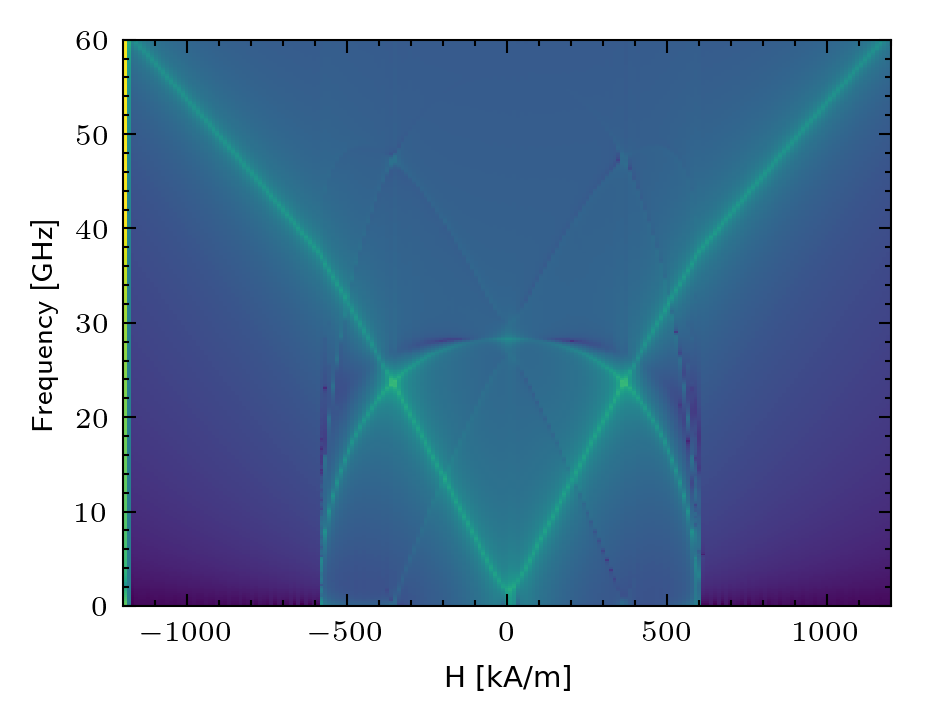

In [ ]:
from cmtj.utils import calculate_resistance_series
import matplotlib.pyplot as plt
from cmtj.utils.linear import FieldScan
from cmtj.utils.procedures import ResistanceParameters, PIMM_procedure

rp = ResistanceParameters(Rxx0=100,
                          Rxy0=1,
                          Rsmr=-0.46,
                          Rahe=-2.7,
                          Ramr=-0.24,
                          l=30,
                          w=20)

# approximate demagnetisation tensor
demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
alpha = 0.005
Kdir = CVector(1, 0, 0)
Ms = 1.65
l1 = Layer("free",
           mag=CVector(0, 0, 1),
           anis=Kdir,
           Ms=Ms,
           thickness=3.99e-9,
           cellSurface=0,
           demagTensor=demag,
           damping=alpha)

l2 = Layer("bottom",
           mag=CVector(0, 0, 1),
           anis=Kdir,
           Ms=Ms,
           thickness=4e-9,
           cellSurface=0,
           demagTensor=demag,
           damping=alpha)
J1 = -1.78e-3
J2 = -1.69e-4

K1 = K2 = 1.05e3
int_step = 4e-14

j1 = Junction([l1, l2], 100, 102)

j1.setLayerAnisotropyDriver("all", ScalarDriver.getConstantDriver(K1))
j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J1))
j1.setQuadIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J2))
# j1.runSimulation(5e-9, 1e-13, 1e-12)
Hscan, Hvecs = FieldScan.amplitude_scan(-1200e3, 1200e3, 200, 89, 90)

spectrum, freqs, output = PIMM_procedure(j1,
                                         Hvecs=Hvecs,
                                         int_step=int_step,
                                         resistance_params=[rp, rp],
                                         max_frequency=60e9)
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    ax.pcolor(Hscan / 1e3,
              freqs / 1e9,
              np.log10(np.squeeze(spectrum.T)),
              cmap='viridis')
    ax.set_xlabel("H [$\mathrm{$\mathrm{kAm^{-1}}$}$]")
    ax.set_ylabel("Frequency [GHz]")